In [ ]:
# default_exp diffusion_flow_embedding
from nbdev.showdoc import *
import numpy as np
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# export
# hide
import torch
import numpy as np
import matplotlib.pyplot as plt

# A collection of Loss functions for Flow Embedder

## Compute Affinity matrix

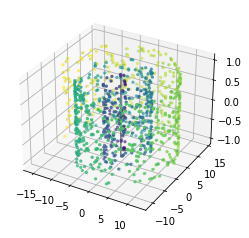

In [ ]:
from directed_graphs.datasets import directed_swiss_roll_uniform, plot_directed_3d
X, flow, labels = directed_swiss_roll_uniform(num_nodes=1000, num_spirals=2.5, radius=1, height=2, xtilt=0, ytilt=0)
plot_directed_3d(X, flow, labels, mask_prob=0.5)

In [ ]:
X = torch.tensor(X)
flow = torch.tensor(flow)

### Anisotropic Symmetric Affinity

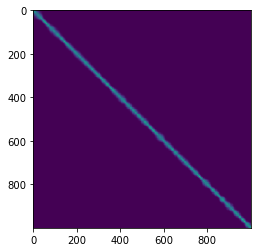

In [ ]:
from directed_graphs.diffusion_flow_embedding import anisotropic_kernel
D = torch.cdist(X, X)
W = anisotropic_kernel(D, sigma=1, alpha=0.25)
plt.imshow(W)

### Flow Assymetrical Affinity

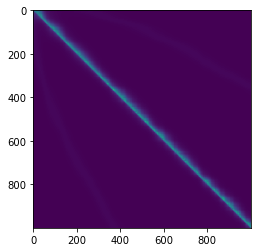

In [ ]:
from directed_graphs.diffusion_flow_embedding import affinity_matrix_from_pointset_to_pointset
W = affinity_matrix_from_pointset_to_pointset(X, X, flow, sigma=2, flow_strength=2)
plt.imshow(W)

## Loss functions

In [ ]:
from directed_graphs.datasets import directed_swiss_roll_sklearn
num_nodes = 1000
graph_dims = 3
embedding_dims = 2
X, ground_truth_flows, labels = directed_swiss_roll_sklearn(num_nodes=num_nodes)
X = torch.tensor(X).float()
ground_truth_flows = torch.tensor(ground_truth_flows).float()
embedded_points = torch.rand(num_nodes, embedding_dims)
embedded_flows = torch.rand(num_nodes, embedding_dims)

In [ ]:
from directed_graphs.diffusion_flow_embedding import affinity_matrix_from_pointset_to_pointset
P_graph = affinity_matrix_from_pointset_to_pointset(X, X, ground_truth_flows, sigma=1, flow_strength=1)
P_embedding = affinity_matrix_from_pointset_to_pointset(embedded_points, embedded_points, embedded_flows)

## KL Divergence

In [ ]:
# export
def kl_divergence_loss(KLD, P_graph, P_embedding):
  P_embedding = torch.log(P_embedding)
  if KLD.log_target:
    P_graph = torch.log(P_graph)
  if P_embedding.is_sparse:
    P_embedding = P_embedding.to_dense()
    P_graph = P_graph.to_dense()
  loss = KLD(P_embedding, P_graph)
  return loss

In [ ]:
KLD = torch.nn.KLDivLoss(reduction='batchmean', log_target=False)
print(f"KL(P_graph     || P_embedding) = {kl_divergence_loss(KLD, P_graph, P_embedding)}")
print(f"KL(P_embedding || P_graph    ) = {kl_divergence_loss(KLD, P_embedding, P_graph)}")

KL(P_graph     || P_embedding) = -0.10641839355230331
KL(P_embedding || P_graph    ) = 44.96841812133789


## Symmetric KL Divergence

In [ ]:
# export
def kld_symmetric_loss(KLD, P_graph, P_embedding):
  loss = (kl_divergence_loss(KLD, P_graph, P_embedding) + kl_divergence_loss(KLD, P_embedding, P_graph)) / 2
  return loss

In [ ]:
print(f"Symmetric KL(P_graph, P_embedding) = {kld_symmetric_loss(KLD, P_graph, P_embedding)}")

Symmetric KL(P_graph, P_embedding) = 22.430999755859375


## Diffusion Map MSE

In [ ]:
# export
def diffusion_map_loss(P_graph, embedded_points):
  num_nodes = P_graph.shape[0]
  D_graph = torch.cdist(P_graph, P_graph)
  D_embedding = torch.cdist(embedded_points, embedded_points)
  loss = torch.norm(D_graph - D_embedding)**2 / (num_nodes**2)
  return loss

In [ ]:
print(f"DM(P_graph, embedded_points) = {diffusion_map_loss(P_graph, embedded_points)}")

DM(P_graph, embedded_points) = 0.18281541764736176


# Diffusion Map MSE (with precomputed diffusion map)
This is a general loss function that applies to any matrix of precomputed distances -- be they shortest path distances, or diffusion distances.

In [ ]:
# export
def precomputed_distance_loss(precomputed_distances, embedded_points):
    D_graph = precomputed_distances
    num_nodes = embedded_points.shape[0]
    D_embedding = torch.cdist(embedded_points, embedded_points)
    loss = torch.norm(D_graph - D_embedding)**2 / (num_nodes**2)
    return loss

## Flow Cosine MSE

In [ ]:
# export
def flow_cosine_loss(X, ground_truth_flows, embedded_flows):
  cosine_graph = ground_truth_flows @ ground_truth_flows.T
  cosine_embedding = embedded_flows @ embedded_flows.T
  W = torch.exp(-torch.cdist(X, X))
  loss = torch.sum((cosine_graph - cosine_embedding)**2 * W) / torch.sum(W)
  return loss

In [ ]:
print(f"Flow Similarity(X, flows, embedded_flows) = {flow_cosine_loss(X, ground_truth_flows, embedded_flows)}")

Flow Similarity(X, flows, embedded_flows) = 0.3838597536087036


## Flow Neighbor MSE

In [ ]:
# export
def directed_neighbors(num_nodes, P_graph, n_neighbors=5):
  # remove self loop
  P_graph = P_graph - torch.eye(num_nodes).to(P_graph.device)
  # return k nearest neighbor indices
  _, neighbors = torch.topk(P_graph, n_neighbors)
  # convert to edge_index format
  row = torch.arange(num_nodes).repeat_interleave(n_neighbors).to(P_graph.device)
  col = neighbors.flatten().to(P_graph.device)
  return torch.stack((row, col))

In [ ]:
neighbors = directed_neighbors(num_nodes, P_graph, n_neighbors=5)
neighbors[:,:5]

tensor([[ 0,  0,  0,  0,  0],
        [27, 22, 58, 25, 57]])

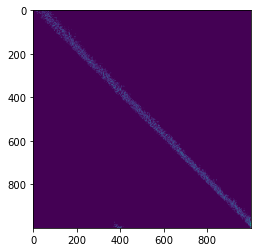

In [ ]:
def plot_sparse(num_nodes, edge_index):
  row, col = edge_index
  dense_adj = np.zeros((num_nodes, num_nodes))
  for r, c in zip(row, col):
    dense_adj[r,c] = 1
  plt.imshow(dense_adj)

plot_sparse(num_nodes, neighbors)

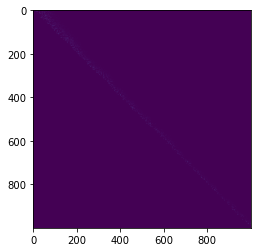

In [ ]:
plt.imshow(P_graph)

In [ ]:
upper = 0
lower = 0
row, col = neighbors
for r, c in zip(row, col):
  if r < c:
    upper += 1
  else:
    lower += 1
print(upper, lower)

4946 54


In [ ]:
# export
def flow_neighbor_loss(neighbors, embedded_points, embedded_flows):
  row, col = neighbors
  directions = embedded_points[col,:] - embedded_points[row,:]
  flows = embedded_flows[row,:]
  loss = torch.norm(directions - flows)**2
  return loss

In [ ]:
flow_neighbor_loss(neighbors, embedded_points, embedded_flows)

tensor(510.8283)

In [ ]:
# export
import torch.nn.functional as F
def flow_neighbor_cosine_loss(neighbors, embedded_points, embedded_flows):
  row, col = neighbors
  directions = embedded_points[col,:] - embedded_points[row,:]
  flows = embedded_flows[row,:]
  normed_directions = F.normalize(directions, dim=-1)
  normed_flows = F.normalize(flows, dim=-1)
  loss = torch.norm(normed_directions * normed_flows)**2
  return loss

In [ ]:
flow_neighbor_cosine_loss(neighbors, embedded_points, embedded_flows)

tensor(2511.9502)